### BLOQUE 1: CONFIGURACIÓN Y UTILIDADES

In [30]:
# BLOQUE 1: CONFIGURACIÓN Y UTILIDADES
import cv2
import pytesseract
from pytesseract import Output
import easyocr
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import time
from pathlib import Path
import pandas as pd

# =================== CONFIGURACIÓN ===================
DATASET_DIR = "../Matriculas"
LABELS_DIR = os.path.join(DATASET_DIR, "labels")
IMAGES_DIR = DATASET_DIR
OCR_LANG = "en"
TESSERACT_PATH = r"C:\Program Files\Tesseract-OCR\tesseract.exe"  # CAMBIAR SI ES NECESARIO
OUTPUT_DIR = "ocr_comparison_results"
RESULTS_CSV = os.path.join(OUTPUT_DIR, "comparativa_ocr.csv")
SAVE_EXAMPLES = True

# Crear carpetas
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "ejemplos"), exist_ok=True)

# Configuración Tesseract
pytesseract.pytesseract.tesseract_cmd = TESSERACT_PATH

# Dispositivo
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Usando dispositivo: {device.upper()}")

# =================== UTILIDADES ===================
def read_yolo_label(label_path):
    try:
        with open(label_path, 'r') as f:
            line = f.readline().strip()
            parts = line.split()
            if len(parts) >= 5:
                return list(map(float, parts[1:5]))
    except:
        pass
    return None

def yolo_to_bbox(yolo_coords, img_shape):
    h, w = img_shape[:2]
    x_center, y_center, box_w, box_h = yolo_coords
    x1 = int((x_center - box_w/2) * w)
    y1 = int((y_center - box_h/2) * h)
    x2 = int((x_center + box_w/2) * w)
    y2 = int((y_center + box_h/2) * h)
    return max(0, x1), max(0, y1), min(w, x2), min(h, y2)

def clean_text(text):
    return re.sub(r"[^A-Z0-9]", "", text.upper())

def fix_common_errors(text):
    text = text.replace('O', '0').replace('I', '1').replace('Q', '0')
    return text

def calculate_levenshtein(s1, s2):
    if len(s1) < len(s2):
        return calculate_levenshtein(s2, s1)
    if len(s2) == 0:
        return len(s1)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

def extract_ground_truth(filename):
    return clean_text(Path(filename).stem)

def calculate_accuracy(predicted, ground_truth):
    if len(predicted) == 0 or len(ground_truth) == 0:
        return 0.0
    max_len = max(len(predicted), len(ground_truth))
    matches = sum(1 for i in range(max_len)
                  if i < len(predicted) and i < len(ground_truth)
                  and predicted[i] == ground_truth[i])
    return (matches / max_len) * 100

print("Bloque 1: Configuración y utilidades cargadas.")

Usando dispositivo: CUDA
Bloque 1: Configuración y utilidades cargadas.


### BLOQUE 2: CARGA DE MODELOS OCR

In [31]:
# BLOQUE 2: CARGA DE MODELOS OCR
print("Cargando EasyOCR...")
reader = easyocr.Reader([OCR_LANG], gpu=(device == 'cuda'))
print("✓ EasyOCR cargado")

# Tesseract ya está configurado en el bloque anterior
print("✓ Tesseract listo (ruta configurada)")
print("\nModelos OCR cargados correctamente.")

Cargando EasyOCR...
✓ EasyOCR cargado
✓ Tesseract listo (ruta configurada)

Modelos OCR cargados correctamente.


### BLOQUE 3: FUNCIONES OCR (EasyOCR + Tesseract)

In [32]:
# BLOQUE 3: FUNCIONES OCR
def normalize_plate(text, ground_truth=""):
    text = clean_text(text)
    text = fix_common_errors(text)
    valid_letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    nums = ''.join(c for c in text if c.isdigit())
    lets = ''.join(c for c in text if c.isalpha())
    patterns = []

    # 1. NNNNLLL
    if len(nums) >= 4 and len(lets) >= 3:
        patterns.append(nums[:4] + lets[-3:])
        patterns.append(lets[:3] + nums[:4])
    # 2. LLNNNNLL (provincial)
    if len(nums) >= 4 and len(lets) >= 4:
        patterns.append(lets[:2] + nums[:4] + lets[2:4])
        patterns.append(nums[:4] + lets[:2] + lets[2:4])
        patterns.append(nums[:4] + lets[:4])
    # 3. LNNNNLL / LNNNNLLL
    if len(nums) >= 4 and len(lets) >= 3:
        patterns.append(lets[0] + nums[:4] + lets[1:3])
        patterns.append(nums[:4] + lets[0] + lets[1:3])
        if len(lets) >= 4:
            patterns.append(lets[0] + nums[:4] + lets[1:4])
            patterns.append(nums[:4] + lets[0] + lets[1:4])
    # 4. LNNLL
    if len(nums) >= 2 and len(lets) >= 4:
        patterns.append(lets[0] + nums[:2] + lets[1:4])
    patterns.append(text)

    if not ground_truth:
        return nums[:4] + lets[-3:] if len(nums) >= 4 and len(lets) >= 3 else text

    best_pattern = ""
    min_dist = 100
    for p in set(patterns):
        if not p: continue
        dist = calculate_levenshtein(p, ground_truth)
        if dist < min_dist or (dist == min_dist and len(p) > len(best_pattern)):
            min_dist = dist
            best_pattern = p
    return best_pattern

def process_image_ocr(img_path, label_path, ground_truth, save_example=False):
    img = cv2.imread(img_path)
    if img is None:
        return None

    yolo_coords = read_yolo_label(label_path)
    if yolo_coords is None:
        return None

    x1, y1, x2, y2 = yolo_to_bbox(yolo_coords, img.shape)
    is_modern = ground_truth and (ground_truth[0].isdigit() or ground_truth.startswith(('GC', 'TF')))
    x1_new = x1 + int((x2 - x1) * 0.12) if is_modern else x1
    crop = img[y1:y2, x1_new:x2].copy()
    if crop.size == 0:
        return None

    crop_resized = cv2.resize(crop, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)

    # --- EASYOCR ---
    start = time.time()
    easy_raw = ""
    try:
        results = reader.readtext(crop_resized, paragraph=True, detail=0)
        easy_raw = " ".join(results).upper()
    except: pass
    easy_norm = normalize_plate(easy_raw, ground_truth)
    easy_time = time.time() - start

    # --- TESSERACT ---
    gray = cv2.cvtColor(crop_resized, cv2.COLOR_BGR2GRAY)
    _, enhanced = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    tess_config = '--oem 1 --psm 7 -l spa -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    start = time.time()
    tess_raw = ""
    try:
        tess_raw = pytesseract.image_to_string(enhanced, config=tess_config).strip().upper()
    except: pass
    tess_norm = normalize_plate(tess_raw, ground_truth)
    tess_time = time.time() - start

    # Guardar ejemplo
    if save_example:
        fig, axes = plt.subplots(1, 3, figsize=(12, 3))
        img_vis = img.copy()
        cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
        axes[0].imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
        axes[0].set_title(f'GT: {ground_truth}')
        axes[0].axis('off')
        axes[1].imshow(cv2.cvtColor(crop_resized, cv2.COLOR_BGR2RGB))
        axes[1].set_title(f'EasyOCR: {easy_norm}')
        axes[1].axis('off')
        easy_color = 'green' if easy_norm == ground_truth else 'red'
        tess_color = 'green' if tess_norm == ground_truth else 'red'
        axes[2].text(0.5, 0.7, f'GT:\n{ground_truth}', ha='center', va='center', fontsize=14, fontweight='bold')
        axes[2].text(0.5, 0.45, f'EasyOCR:\n{easy_norm}', ha='center', va='center', fontsize=12, color=easy_color, fontweight='bold')
        axes[2].text(0.5, 0.25, f'Tesseract:\n{tess_norm}', ha='center', va='center', fontsize=12, color=tess_color, fontweight='bold')
        axes[2].axis('off')
        plt.tight_layout()
        plt.savefig(f"{OUTPUT_DIR}/ejemplos/{Path(img_path).stem}.png", dpi=120)
        plt.close()

    return {
        'imagen': Path(img_path).name,
        'ground_truth': ground_truth,
        'easy_raw': easy_raw,
        'easy_normalized': easy_norm,
        'easy_correct': (easy_norm == ground_truth),
        'easy_accuracy': calculate_accuracy(easy_norm, ground_truth),
        'easy_levenshtein': calculate_levenshtein(easy_norm, ground_truth),
        'easy_time': easy_time,
        'tess_raw': tess_raw,
        'tess_normalized': tess_norm,
        'tess_correct': (tess_norm == ground_truth),
        'tess_accuracy': calculate_accuracy(tess_norm, ground_truth),
        'tess_levenshtein': calculate_levenshtein(tess_norm, ground_truth),
        'tess_time': tess_time
    }

print("Bloque 3: Funciones OCR definidas.")

Bloque 3: Funciones OCR definidas.


### BLOQUE 4: PRUEBA CON UNA IMAGEN

In [33]:
# BLOQUE 4: PRUEBA CON UNA IMAGEN (elige una)
label_files = [f for f in os.listdir(LABELS_DIR) if f.endswith('.txt') and f != 'classes.txt']
if not label_files:
    print("No se encontraron labels.")
else:
    test_label = label_files[0]
    base_name = Path(test_label).stem
    img_path = None
    for ext in ['.jpg', '.jpeg', '.JPG', '.JPEG', '.png', '.PNG']:
        candidate = os.path.join(IMAGES_DIR, base_name + ext)
        if os.path.exists(candidate):
            img_path = candidate
            break
    if img_path:
        label_path = os.path.join(LABELS_DIR, test_label)
        gt = extract_ground_truth(img_path)
        print(f"Probando con: {Path(img_path).name}")
        result = process_image_ocr(img_path, label_path, gt, save_example=True)
        if result:
            print(f"GT: {result['ground_truth']}")
            print(f"EasyOCR:  {result['easy_normalized']} → {'✓' if result['easy_correct'] else '✗'}")
            print(f"Tesseract: {result['tess_normalized']} → {'✓' if result['tess_correct'] else '✗'}")
        else:
            print("Error al procesar la imagen.")
    else:
        print("No se encontró imagen para el label.")

Probando con: 0116GPD.jpg
GT: 0116GPD
EasyOCR:  0116GPD → ✓
Tesseract: 0116GPD → ✓


### BLOQUE 5: PROCESAMIENTO COMPLETO DEL DATASET

In [34]:
# BLOQUE 5: PROCESAMIENTO COMPLETO
print("Buscando imágenes con labels...")
label_files = [f for f in os.listdir(LABELS_DIR) if f.endswith('.txt') and f != 'classes.txt']
img_label_pairs = []
for label_file in label_files:
    base_name = Path(label_file).stem
    for ext in ['.jpg', '.jpeg', '.JPG', '.JPEG', '.png', '.PNG']:
        img_path = os.path.join(IMAGES_DIR, base_name + ext)
        if os.path.exists(img_path):
            img_label_pairs.append((base_name + ext, label_file))
            break

total = len(img_label_pairs)
print(f"Encontradas {total} imágenes con labels\n")
print("="*70)

results_list = []
for idx, (img_file, label_file) in enumerate(img_label_pairs, 1):
    img_path = os.path.join(IMAGES_DIR, img_file)
    label_path = os.path.join(LABELS_DIR, label_file)
    ground_truth = extract_ground_truth(img_file)
    save_ex = SAVE_EXAMPLES and idx <= 15
    result = process_image_ocr(img_path, label_path, ground_truth, save_ex)
    if result:
        results_list.append(result)
        easy_icon = '✓' if result['easy_correct'] else '✗'
        tess_icon = '✓' if result['tess_correct'] else '✗'
        print(f"[{idx}/{total}] {img_file}")
        print(f"  GT: {ground_truth}")
        print(f"  EasyOCR:   {result['easy_normalized']:12s} {easy_icon} (Acc: {result['easy_accuracy']:5.1f}%, {result['easy_time']:.3f}s)")
        print(f"  Tesseract: {result['tess_normalized']:12s} {tess_icon} (Acc: {result['tess_accuracy']:5.1f}%, {result['tess_time']:.3f}s)")
        print()

# Guardar CSV
df = pd.DataFrame(results_list)
df.to_csv(RESULTS_CSV, index=False, encoding='utf-8-sig')
print("="*70)
print(f"Resultados guardados: {RESULTS_CSV}")
print(f"Procesadas: {len(results_list)}/{total} imágenes")
print("="*70)

Buscando imágenes con labels...
Encontradas 57 imágenes con labels

[1/57] 0116GPD.jpg
  GT: 0116GPD
  EasyOCR:   0116GPD      ✓ (Acc: 100.0%, 0.052s)
  Tesseract: 0116GPD      ✓ (Acc: 100.0%, 0.203s)

[2/57] 0116HGV.jpg
  GT: 0116HGV
  EasyOCR:   10116HGV     ✗ (Acc:  12.5%, 0.045s)
  Tesseract: WT           ✗ (Acc:   0.0%, 0.199s)

[3/57] 0290KWT.jpg
  GT: 0290KWT
  EasyOCR:   00290KWT     ✗ (Acc:  12.5%, 0.217s)
  Tesseract: 0A           ✗ (Acc:  14.3%, 0.203s)

[4/57] 0303BML.jpg
  GT: 0303BML
  EasyOCR:   10303BML     ✗ (Acc:   0.0%, 0.192s)
  Tesseract: 0303BML      ✓ (Acc: 100.0%, 0.195s)

[5/57] 0416MLX.jpg
  GT: 0416MLX
  EasyOCR:                ✗ (Acc:   0.0%, 0.405s)
  Tesseract:              ✗ (Acc:   0.0%, 0.380s)

[6/57] 0476MNN.jpg
  GT: 0476MNN
  EasyOCR:   0476MNN      ✓ (Acc: 100.0%, 0.049s)
  Tesseract: 0176N        ✗ (Acc:  42.9%, 0.196s)

[7/57] 0576MSH.jpg
  GT: 0576MSH
  EasyOCR:   J06MSH       ✗ (Acc:   0.0%, 0.602s)
  Tesseract: 0576MSH      ✓ (Acc: 100.0%, 0.4

### BLOQUE 6: ESTADÍSTICAS Y GRÁFICAS

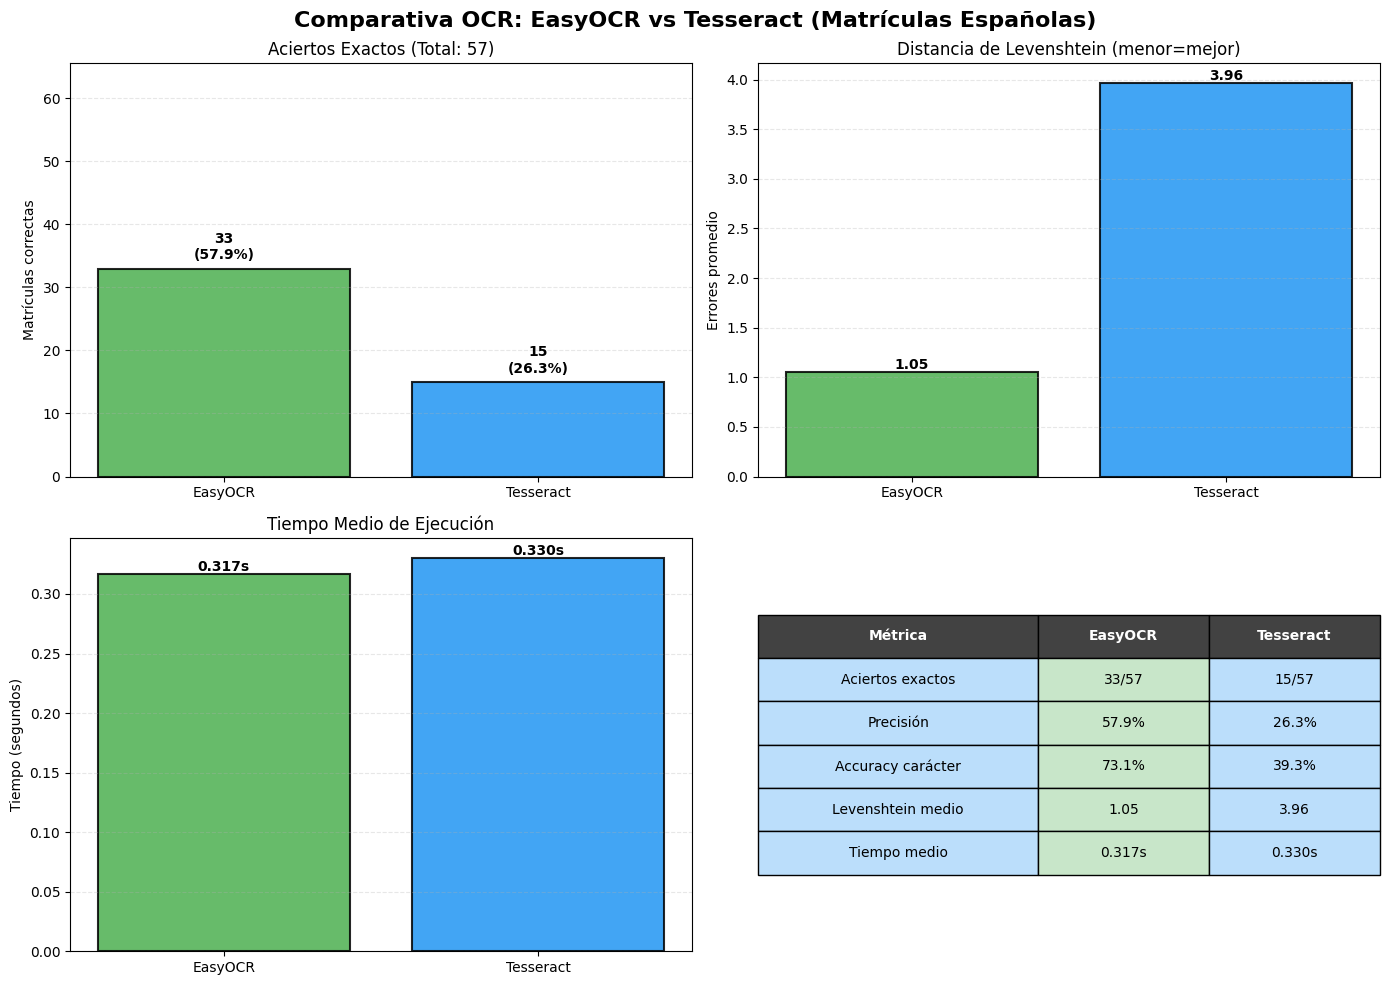

Gráfica guardada: ocr_comparison_results\comparativa_grafica.png


In [35]:
# BLOQUE 6: ESTADÍSTICAS Y GRÁFICAS
if len(results_list) == 0:
    print("No hay resultados para analizar.")
else:
    easy_correct = df['easy_correct'].sum()
    tess_correct = df['tess_correct'].sum()
    easy_avg_acc = df['easy_accuracy'].mean()
    tess_avg_acc = df['tess_accuracy'].mean()
    easy_avg_lev = df['easy_levenshtein'].mean()
    tess_avg_lev = df['tess_levenshtein'].mean()
    easy_avg_time = df['easy_time'].mean()
    tess_avg_time = df['tess_time'].mean()

    # Gráficas
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Comparativa OCR: EasyOCR vs Tesseract (Matrículas Españolas)', fontsize=16, fontweight='bold')
    colors = ['#4CAF50', '#2196F3']

    # Aciertos
    ax1 = axes[0, 0]
    bars = ax1.bar(['EasyOCR', 'Tesseract'], [easy_correct, tess_correct], color=colors, alpha=0.85, edgecolor='black', linewidth=1.5)
    ax1.set_ylabel('Matrículas correctas')
    ax1.set_title(f'Aciertos Exactos (Total: {total})')
    ax1.set_ylim(0, total * 1.15)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    for bar, val in zip(bars, [easy_correct, tess_correct]):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1, f'{val}\n({val/total*100:.1f}%)', ha='center', va='bottom', fontweight='bold')

    # Levenshtein
    ax2 = axes[0, 1]
    bars = ax2.bar(['EasyOCR', 'Tesseract'], [easy_avg_lev, tess_avg_lev], color=colors, alpha=0.85, edgecolor='black', linewidth=1.5)
    ax2.set_ylabel('Errores promedio')
    ax2.set_title('Distancia de Levenshtein (menor=mejor)')
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    for bar, val in zip(bars, [easy_avg_lev, tess_avg_lev]):
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{val:.2f}', ha='center', va='bottom', fontweight='bold')

    # Tiempo
    ax3 = axes[1, 0]
    bars = ax3.bar(['EasyOCR', 'Tesseract'], [easy_avg_time, tess_avg_time], color=colors, alpha=0.85, edgecolor='black', linewidth=1.5)
    ax3.set_ylabel('Tiempo (segundos)')
    ax3.set_title('Tiempo Medio de Ejecución')
    ax3.grid(axis='y', alpha=0.3, linestyle='--')
    for bar, val in zip(bars, [easy_avg_time, tess_avg_time]):
        ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{val:.3f}s', ha='center', va='bottom', fontweight='bold')

    # Tabla
    ax4 = axes[1, 1]
    ax4.axis('off')
    summary = [
        ['Métrica', 'EasyOCR', 'Tesseract'],
        ['Aciertos exactos', f'{easy_correct}/{total}', f'{tess_correct}/{total}'],
        ['Precisión', f'{easy_correct/total*100:.1f}%', f'{tess_correct/total*100:.1f}%'],
        ['Accuracy carácter', f'{easy_avg_acc:.1f}%', f'{tess_avg_acc:.1f}%'],
        ['Levenshtein medio', f'{easy_avg_lev:.2f}', f'{tess_avg_lev:.2f}'],
        ['Tiempo medio', f'{easy_avg_time:.3f}s', f'{tess_avg_time:.3f}s']
    ]
    table = ax4.table(cellText=summary, cellLoc='center', loc='center', colWidths=[0.45, 0.275, 0.275])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2.2)
    for i in range(len(summary)):
        for j in range(3):
            cell = table[(i, j)]
            if i == 0:
                cell.set_facecolor('#424242')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#C8E6C9' if j == 1 else '#BBDEFB')

    plt.tight_layout()
    graph_path = os.path.join(OUTPUT_DIR, 'comparativa_grafica.png')
    plt.savefig(graph_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Gráfica guardada: {graph_path}")